In [1]:
from ioMicro import *
import numpy as np
import os
import dask.array as da
def get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=5,th=0):
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0]),0,0
    if (len(obj_Xh_plus)>0) and (len(obj_ref_Xh_plus)>0):
        X = obj_Xh_plus[obj_Xh_plus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_plus[obj_ref_Xh_plus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_plus,N_plus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if (len(obj_Xh_minus)>0) and (len(obj_ref_Xh_minus)>0):
        X = obj_Xh_minus[obj_Xh_minus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_minus[obj_ref_Xh_minus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_minus,N_minus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if np.max(np.abs(tzxy_minus-tzxy_plus))<=2:
        tzxyf = -(tzxy_plus*N_plus+tzxy_minus*N_minus)/(N_plus+N_minus)
    else:
        tzxyf = -[tzxy_plus,tzxy_minus][np.argmax([N_plus,N_minus])]
    return [tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus]    
def get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0):
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    fl_feats_ref = rf'{save_folder_ref}\{fov}--{htagref}--dapiFeatures.npz'
    obj_Xh_plus,obj_Xh_minus = np.load(fl_feats)['Xh_plus'],np.load(fl_feats)['Xh_minus']
    obj_ref_Xh_plus,obj_ref_Xh_minus = np.load(fl_feats_ref)['Xh_plus'],np.load(fl_feats_ref)['Xh_minus']
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=resc,th=th)
    return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus
def read_im(fl,return_pos=False,ncols=4):
    data = os.path.dirname(fl)+os.sep+os.path.basename(fl).split('_')[-1].split('.')[0]+r'\data'
    im = da.from_zarr(fl,component=data)
    im = im[1:]
    im = im.reshape([-1,ncols,im.shape[-2],im.shape[-1]])
    im = im.swapaxes(0,1)
    
    im=im.astype(np.float32)
    im=im*im
    if return_pos is False:
        return im
    else:
        fl_xml = fl.replace('.zarr','.xml')
        x,y = [eval(ln.split('>')[1].split('<')[0]) for ln in open(fl_xml) if 'stage_position' in ln][0]
        return im,x,y

In [2]:
fov = 'Conv_zscan1__434'
htags = [rf'H{i+1}' for i in np.arange(9)]
save_folder = r'S:\12_04_2025_JenieSample\fits'
os.makedirs(save_folder,exist_ok=True)
master_folder = r'S:\12_04_2025_JenieSample'
psf = pickle.load(open('psf_final.pkl','rb'))

In [6]:
psfs = np.array(list(psf.values()))
import napari
napari.view_image(psfs)

Viewer(camera=Camera(center=(0.0, np.float64(54.5), np.float64(54.5)), zoom=np.float64(2.2994318181818176), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(np.float64(24.0), np.float64(9.0), 0.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=4, ndisplay=2, order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3'), rollable=(True, True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(48.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(19.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(109.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(109.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0, 0.0), point=(np.float64(24.0), np.float64(9.0), np.float64(54.0), np.float64(54.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Im

In [4]:
for htag in tqdm(htags):
    fl = master_folder+os.sep+htag+os.sep+fov
    for icol in [0,1,2]:
        fl_save = save_folder+os.sep+f'{fov}--{htag}--col{icol}__Xhfits.npz'
        if not os.path.exists(fl_save) or True:
            im = np.array(read_im(fl)[icol])
            med = np.load(f'med{icol}.npy')
            med = cv2.blur(med,(20,20))
            med = med/np.median(med)
            im_ = im/med
            Xh = get_local_max_tile(im_,
                th=4000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.0001},
                delta=1,
                delta_fit=3,
                sigmaZ=1,
                sigmaXY=1.5,
            )
            
            np.savez_compressed(fl_save,Xh=Xh)
    icol=3
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    if not os.path.exists(fl_feats) or True:
        im = np.array(read_im(fl)[icol])
        med = np.load(f'med{icol}.npy')
        med = cv2.blur(med,(20,20))
        med = med/np.median(med)
        im_ = im/med
        Xh_plus = get_local_max_tile(im_,
                th=5000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.01},
                delta=5,
                delta_fit=5,
                sigmaZ=1,
                sigmaXY=1.5,
            )
        Xh_minus = get_local_max_tile(-im_,
                th=5000,
                s_=400,
                pad=100,
                psf=psf,
                plt_val=None,
                snorm=30,
                gpu=True,
                deconv={'method': 'wiener', 'beta': 0.01},
                delta=3,
                delta_fit=3,
                sigmaZ=1,
                sigmaXY=1.5,
            )
        np.savez_compressed(fl_feats,Xh_plus=Xh_plus,Xh_minus=Xh_minus)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [19:36<00:00, 130.73s/it]


In [4]:
### Align the different hybes to the reference #H1

In [6]:
fov = 'Conv_zscan1__434'
save_folder =save_folder_ref= r'S:\12_04_2025_JenieSample\fits'

htags = [rf'H{i+1}' for i in np.arange(9)]
htagref = htags[0]
### compute drift for all MERFISH rounds
drift_fl = save_folder+os.sep+'driftNew_'+fov+'--.pkl'
if not os.path.exists(drift_fl) or True:
    newdrifts = []
    for htag in htags:
        drft = get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0)
        print(htag,drft)
        newdrifts.append(drft)
    pickle.dump([newdrifts,htags,fov,htagref],open(drift_fl,'wb'))

H1 (array([-0., -0., -0.]), array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32), np.int64(5371), np.int64(3762))
H2 (array([ 0.45159385, -4.66594932,  0.83863813]), array([-0.44491914,  4.678531  , -0.8526588 ], dtype=float32), array([-0.4657507,  4.6392636, -0.8089007], dtype=float32), np.int64(2104), np.int64(992))
H3 (array([ 0.41284656, -4.16715517,  3.22535373]), array([-0.4183824,  4.142248 , -3.2267249], dtype=float32), array([-0.40063307,  4.2221065 , -3.2223287 ], dtype=float32), np.int64(1904), np.int64(863))
H4 (array([-0.06830737, -3.52101633,  6.66201056]), array([ 0.06706093,  3.5237398 , -6.6577344 ], dtype=float32), array([ 0.07111906,  3.5148728 , -6.6716566 ], dtype=float32), np.int64(2249), np.int64(997))
H5 (array([-0.12190216, -8.11458801,  5.68687921]), array([ 0.12420164,  8.099087  , -5.679617  ], dtype=float32), array([ 0.11436498,  8.165398  , -5.7106833 ], dtype=float32), np.int64(1534), np.int64(468))
H6 (array([1.20715002, 0.17256315, 3.7

In [7]:
dec = decoder_simple(save_folder,fov=fov,set_='')
dec.get_XH(fov,'',ncols=3,nbits=100,th_h=4000,tag_keep='',
           color_fl=None,#r'\\192.168.0.114\apple5\Yuanyi\Cerebellum_MER20CRISPR_2wks_09_10_2025\3color_coorection_Scope3.pkl',
           medH_fl=None)#r'\\192.168.0.114\apple5\Yuanyi\Cerebellum_MER20CRISPR_2wks_09_10_2025\medHBRBB_yuanyi_scope3.npz')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(873095, 8)
(1049887, 8)
(1133365, 8)


 11%|█████████▎                                                                          | 1/9 [00:01<00:14,  1.76s/it]

(567302, 8)
(1104201, 8)
(1196892, 8)


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:12,  1.72s/it]

(626167, 8)
(899335, 8)
(1098044, 8)


 33%|████████████████████████████                                                        | 3/9 [00:05<00:09,  1.65s/it]

(504500, 8)
(973101, 8)
(1173570, 8)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:06<00:08,  1.62s/it]

(497568, 8)
(970092, 8)
(1007257, 8)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:08<00:06,  1.56s/it]

(493911, 8)
(950864, 8)
(1109219, 8)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:09<00:04,  1.55s/it]

(446006, 8)
(973123, 8)
(1163218, 8)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:11<00:03,  1.54s/it]

(572058, 8)
(932400, 8)
(1103622, 8)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:12<00:01,  1.55s/it]

(442644, 8)
(839277, 8)
(1165992, 8)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.59s/it]


In [9]:
def get_icodesV3(dec,nmin_bits=3,iH=-3,save=False,make_unique=False):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64)
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__))
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis]
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    dec.dist_best = dists_best_.numpy()
    if make_unique:
        indexMols_,rinvMols = get_unique_ordered(indexMols_)
        icodesN = icodesN[rinvMols]
        dec.dist_best = dists_best_[rinvMols].numpy()
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    if save:
        np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)

In [13]:
cor = dec.XH[:,-4-2] 
bit = dec.XH[:,-1].astype(int)
ubits = np.unique(bit)
H = dec.XH[:,-3]
medH=np.array([np.median(H[(cor>0.5)&(bit==ubit)]) for ubit in ubits])
medH = medH/np.median(medH)

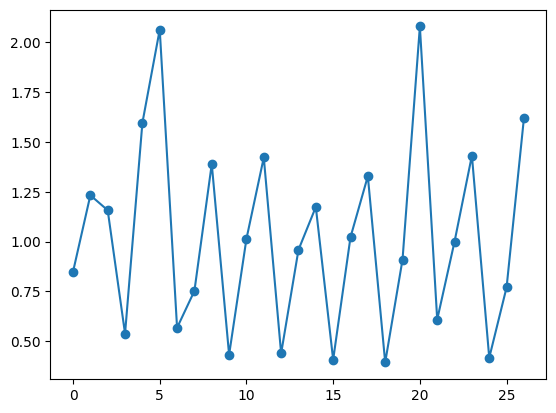

In [14]:
plt.plot(medH,'o-')

In [15]:
Hcor = medH[bit]
dec.XH[:,-3] = dec.XH[:,-3]/Hcor
medH_fl = r'medHBRBB.npz'
medHs = np.savez(medH_fl,medHs=medH)

In [17]:
dec.XH.shape### number of molecules (local maxima) x : z,x,y,...,cor_psf_raw,h_raw,cor_psf_deconv,h_deconv

(23866710, 10)

In [24]:
dec.XH = dec.XH[dec.XH[:,-4]>0.7]
dec.ncols = 3
lib_fl = r'codebook_BRBB_500Markergn_NewAdaptors.csv'
dec.load_library(lib_fl,nblanks=-1)
get_intersV2(dec,nmin_bits=3,dinstance_th=3,enforce_color=False,enforce_set=None,redo=False) #default:redo = False
get_icodesV3(dec,nmin_bits=3,iH=-3)

Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\fits\resNew_Conv_zscan1__434--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 1.9127719402313232
Computing score...
Total time computing score: 0.08294224739074707
Computing sorting...
Total time sorting molecules by score: 1.279090404510498
Finding best bits per molecules...
Finding best code...


100%|███████████████████████████████████████████████████████████████████████████████| 638/638 [00:01<00:00, 388.94it/s]


Total time best bits per molecule: 2.519883155822754


C:\Users\User\AppData\Local\Temp\ipykernel_29040\4173420293.py:17: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


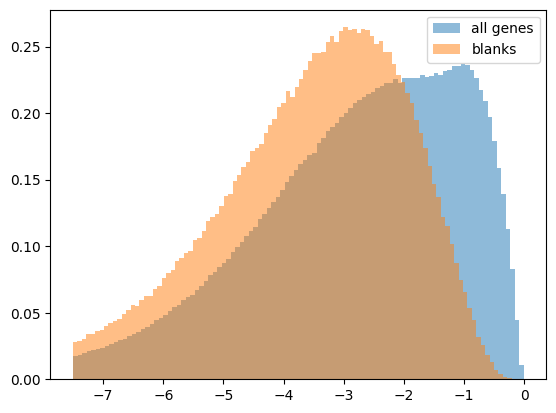

In [26]:
get_score(dec)

scores_ref_fl = save_folder+os.sep+'scores_BRBB.npy'
if not os.path.exists(scores_ref_fl) or True:
    score_ref = np.sort(dec.score,axis=0)
    dec.score_ref = score_ref
    np.save(scores_ref_fl,score_ref)
else:
    dec.score_ref = np.load(scores_ref_fl)
    
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

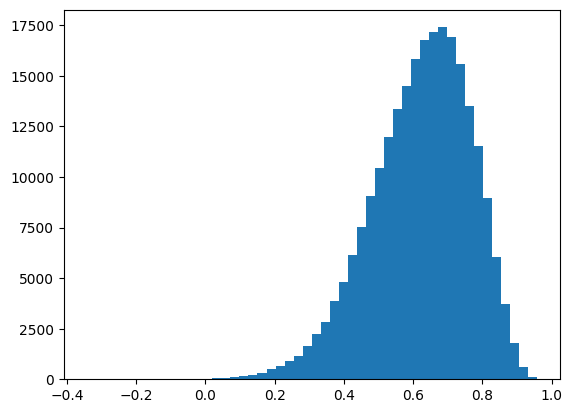

In [22]:
plt.hist(dec.XH[::100,-4],bins=50);

In [9]:
dec.ncols = 3
lib_fl = r'codebook_BRBB_500Markergn_NewAdaptors.csv'
dec.load_library(lib_fl,nblanks=-1)
get_intersV2(dec,nmin_bits=3,dinstance_th=3,enforce_color=False,enforce_set=None,redo=False) #default:redo = False
get_icodesV3(dec,nmin_bits=3,iH=-3)




Calculating lengths of clusters...
Unfolding indexes...
Saving to file: S:\12_04_2025_JenieSample\fits\resNew_Conv_zscan1__434--.npz
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 9.008276224136353
Computing score...
Total time computing score: 0.23204398155212402
Computing sorting...
Total time sorting molecules by score: 4.274180889129639
Finding best bits per molecules...
Finding best code...


100%|█████████████████████████████████████████████████████████████████████████████| 1963/1963 [00:04<00:00, 416.01it/s]


Total time best bits per molecule: 7.375470876693726


In [10]:
#get_icodesV3(dec,nmin_bits=3,iH=-3)

In [25]:
def get_score(dec):
    H = np.nanmedian(dec.XH_pruned[...,-3],axis=1)
    n1bits = dec.XH_pruned.shape[1]
    from itertools import combinations
    combs = np.array(list(combinations(np.arange(n1bits),2)))
    X = dec.XH_pruned[:,:,:3]
    D = np.nanmean(np.linalg.norm(X[:,combs][:,:,0]-X[:,combs][:,:,1],axis=-1),axis=1)
    db = dec.dist_best
    score = np.array([H,-D,-db]).T
    #score = np.sort(score,axis=1)
    #score_ref = np.sort(score,axis=0)
    dec.score = score
    return score
def set_scoreA(dec):
    score_ref = dec.score_ref
    score = dec.score
    from scipy.spatial import KDTree
    scoreA = np.zeros(len(score))
    for iS in range(score.shape[-1]):
        dist_,inds_ = KDTree(score_ref[:,[iS]]).query(score[:,[iS]])
        scoreA+=np.log((inds_+1))-np.log(len(score_ref))
    dec.scoreA = scoreA

C:\Users\User\AppData\Local\Temp\ipykernel_41920\4173420293.py:17: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


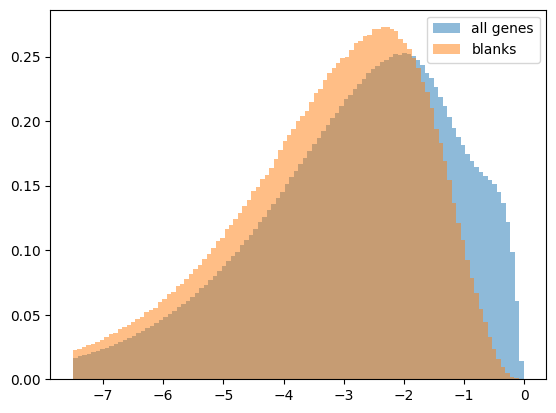

In [12]:
get_score(dec)

scores_ref_fl = save_folder+os.sep+'scores_BRBB.npy'
if not os.path.exists(scores_ref_fl) or True:
    score_ref = np.sort(dec.score,axis=0)
    dec.score_ref = score_ref
    np.save(scores_ref_fl,score_ref)
else:
    dec.score_ref = np.load(scores_ref_fl)
    
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

[np.str_('Slc17a7'), np.str_('Nfix'), np.str_('Rgs4'), np.str_('Ptk2b'), np.str_('Pou3f3'), np.str_('Slc30a3'), np.str_('Slc1a3'), np.str_('Sv2b'), np.str_('Lamp5'), np.str_('Rasgrp1'), np.str_('Cacng3'), np.str_('Zeb2'), np.str_('Grm3'), np.str_('Gpr88'), np.str_('Sulf2'), np.str_('Igfbp2'), np.str_('Igfbp4'), np.str_('Kcng2'), np.str_('Cd34'), np.str_('Ccn3'), np.str_('Gfap'), np.str_('Npnt'), np.str_('Slit3'), np.str_('Zbtb16'), np.str_('Gja1'), np.str_('Tafa2'), np.str_('Fosl2'), np.str_('Nr2f1'), np.str_('Lhx2'), np.str_('Sorcs3')]


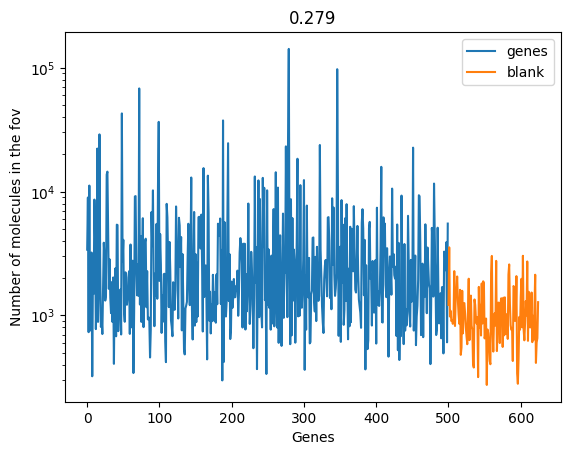

In [28]:
dec.th=-2
dec.gns_names = np.array(dec.gns_names)
plot_statistics(dec)

In [29]:
def plot_multigenes(self,genes=['Gad1','Sox9'],colors=['r','g','b','m','c','y','w'],smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    icodesN,XH_pruned = self.icodesN,self.XH_pruned
    scoreA=self.scoreA
    th=self.th
    gns_names = list(self.gns_names)
    
    Xcms = np.nanmean(XH_pruned,axis=1)
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = icodesN[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        icode = gns_names.index(gene)
        is_code = icode==icodesf
        viewer.add_points(X[is_code][:,1:],size=size[is_code],face_color=color,name=gene,border_width=0)
        #viewer.layers[-1].visible=False
    return viewer

In [30]:
plot_multigenes(dec,genes=['Slc17a7', 'Slc1a3','Gad2','Lamp5','Megf11'])

Viewer(camera=Camera(center=(0.0, np.float64(1393.2795320351918), np.float64(1403.00386540095)), zoom=np.float64(0.20369652035861316), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(-4.920672257741292), stop=np.float64(2792.3318684895835), step=np.float64(1.0)), RangeTuple(start=np.float64(5.612846692403157), stop=np.float64(2810.5327962239585), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1393.0793277422588), np.float64(1402.612846692403)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'Slc17a7' at 0x2174b28a220>, <Points layer 'Slc1a3' at 0x2174c501fd0>, <Points layer 'Gad2' at 0x217513185b0>, <Points layer 'Lamp5' at 0x2174d5104f0>, <Point

### Perform chromatic aberation

In [31]:


XH_pruned = dec.XH_pruned[dec.scoreA>-2] #change this score
color = XH_pruned[:,:,-2]
ucolors=  np.unique(color)
ucolors=ucolors[ucolors>-1]

#align color 0 to color 1

col = 0
col_ref=1

from itertools import combinations
combs = np.array([[i,j] for i in np.arange(color.shape[-1]) for j in np.arange(color.shape[-1])])
color_cmbs = color[:,combs]
X_cmbs = XH_pruned[:,:,:3][:,combs]
#good = ~np.any(np.isnan(color_cmbs),axis=-1)
keep = (color_cmbs[:,:,0]==col_ref)&(color_cmbs[:,:,1]==col)
X1,X2 = X_cmbs[keep].swapaxes(0,1)

import napari
V = napari.view_points(X1,face_color='r',size=3,border_width=0)
V.add_points(X2,face_color='g',size=3,border_width=0)

<Points layer 'X2' at 0x2173bbdac10>

In [32]:
res = 100
vals = np.round(X1/res).astype(int)*res
difs = X1-X2
dic={}
for val,dif in zip (tqdm(vals),difs):
    key = tuple(val)
    if key not in dic: dic[key]=[]
    dic[key].append(dif)
for key in dic:
    dic[key] = np.mean(dic[key],axis=0)
X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D*10
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
#ms = [m,None]
if True:
    import napari
    V=napari.view_points(X1_[:,1:],face_color='r',size=10)
    V.add_points(X2_[:,1:],face_color='g',size=10)
    V.add_points(X2_T[:,1:],face_color='c',size=10)

100%|████████████████████████████████████████████████████████████████████| 1844136/1844136 [00:03<00:00, 601868.29it/s]


In [33]:

X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
ms = [m,None]
#pickle.dump(ms,open('color_correction_BICAN.pkl','wb'))

In [34]:
XH_pruned = dec.XH_pruned[dec.scoreA>-2]
color = XH_pruned[:,:,-2]
ucolors=  np.unique(color)
ucolors=ucolors[ucolors>-1]


from itertools import combinations
combs = np.array([[i,j] for i in np.arange(color.shape[-1]) for j in np.arange(color.shape[-1])])
color_cmbs = color[:,combs]
X_cmbs = XH_pruned[:,:,:3][:,combs]
#good = ~np.any(np.isnan(color_cmbs),axis=-1)
keep = (color_cmbs[:,:,0]==1)&(color_cmbs[:,:,1]==2)
X1,X2 = X_cmbs[keep].swapaxes(0,1)

res = 100
vals = np.round(X1/res).astype(int)*res
difs = X1-X2
dic={}
for val,dif in zip (tqdm(vals),difs):
    key = tuple(val)
    if key not in dic: dic[key]=[]
    dic[key].append(dif)
for key in dic:
    dic[key] = np.mean(dic[key],axis=0)

X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
msf = ms+[m]

100%|████████████████████████████████████████████████████████████████████| 2841719/2841719 [00:04<00:00, 599822.38it/s]


In [35]:
pickle.dump(msf,open(r'3color_coorection_Mammoth.pkl','wb'))

In [36]:
msf

[array([[-3.49781333e-01, -4.82495158e-04, -4.48529237e-04,
         -8.25951948e-05,  1.67331163e-07, -4.47205151e-10,
          1.76281131e-07,  2.72570875e-08, -1.01589934e-08,
          2.61344954e-07],
        [-1.27484312e+00,  7.38754612e-05,  1.20230796e-03,
         -4.99957641e-04, -5.10608253e-08,  4.67812531e-08,
         -1.17561098e-07,  2.15314307e-08,  3.46533923e-07,
         -1.39388257e-07],
        [-1.41336952e+00,  8.58697386e-04, -9.02679009e-06,
         -5.69208908e-04,  6.42805187e-08, -6.11937316e-08,
          3.18818573e-08,  3.54995886e-07,  3.54565523e-08,
          1.01268891e-07]]),
 None,
 array([[-3.91692266e-01,  9.55110525e-05,  8.03272186e-05,
         -2.82975597e-05, -3.78993013e-08, -2.32747127e-09,
         -3.12599263e-08,  7.52880993e-09, -3.27077582e-09,
          1.02505113e-09],
        [ 1.36232723e+00, -2.23059406e-05, -1.15968024e-03,
         -2.01750118e-05,  3.17888466e-08, -5.05756277e-08,
          6.47203328e-08,  1.67097895e-08, 